# Art Painting 이미지를 사용한 정확도 올리기 대회 설명

## <문제>
아래의 **훈련데이터만** 을 사용하여 각 카테고리별로 분류가 잘 되도록 신경망을 구성하세요.  
- **7개**의 카테고리: 'dog' : 0
'elephant' : 1
'giraffe' : 2
'guitar' : 3
'horse' : 4
'house' : 5
'person' : 6

- 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]
- 훈련 데이터는 art painting 1,698장이며 테스트 데이터는 art painting 350장  


## <제출>
소스 코드에 대한 간략한 설명은 다음을 포함해야 합니다.  
- 문제를 어떤 관점에서 정의하였는지
- 문제 해결 위해 만든 모델에 대한 설명과 그 모델을 선택한 이유

In [1]:
!pip install albumentations==0.4.6
!pip install timm

In [2]:
# 필요 라이브러리 로드
import os, sys, random, warnings
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
from torch.utils import data
import torch.nn as nn
from torch.nn.modules.loss import _WeightedLoss
from importlib import import_module
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm


In [3]:
# 경로 설정 

PATH = '/content/drive/MyDrive/Colab Notebooks/dev_match/'
train_path = os.path.join(PATH, 'train/train')
test_path = os.path.join(PATH, 'test/test')

# EDA

이번 대회는 7가지 카테고리를 갖는 이미지 데이터셋을 분류하는 문제입니다.  
문제를 효과적으로 해결하기 위해서는 먼저 어떤 문제인지 명확하게 정의하는 일이 필요합니다.  


이를 위해 먼저 데이터셋을 살펴봅니다.

In [4]:
category_list = ['dog','elephant','giraffe','guitar','horse','house','person']

temp_dict = {'img_dir': [],'label':[],'category':[]}

for label, category in enumerate(category_list):
  for img_dir in os.listdir(os.path.join(train_path, category)):
    dir = os.path.join(category,img_dir)
    temp_dict['img_dir'].append(str(dir))
    temp_dict['label'].append(label)
    temp_dict['category'].append(category)

train_set = pd.DataFrame(temp_dict)
train_set

,img_dir,label,category
0,dog/pic_241.jpg,0,dog
1,dog/pic_249.jpg,0,dog
2,dog/pic_225.jpg,0,dog
3,dog/pic_306.jpg,0,dog
4,dog/pic_219.jpg,0,dog
...,...,...,...
1693,person/pic_402.jpg,6,person
1694,person/pic_397.jpg,6,person
1695,person/pic_412.jpg,6,person
1696,person/pic_414.jpg,6,person


학습 데이터는 총 1,698개가 존재합니다.

In [105]:
temp_dict = {'img_dir': [],'label':[]}
for img_dir in os.listdir(os.path.join(test_path, '0')):
  temp_dict['img_dir'].append(str(os.path.join('0',img_dir)))
  temp_dict['label'].append('-1')

test_set = pd.DataFrame(temp_dict)
test_set

,img_dir,label
0,0/0288.jpg,-1
1,0/0262.jpg,-1
2,0/0311.jpg,-1
3,0/0246.jpg,-1
4,0/0029.jpg,-1
...,...,...
345,0/0102.jpg,-1
346,0/0124.jpg,-1
347,0/0307.jpg,-1
348,0/0332.jpg,-1


test 데이터는 350개가 존재합니다.

### 이미지 시각화

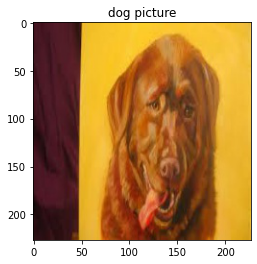

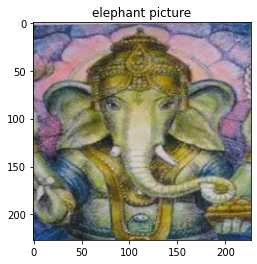

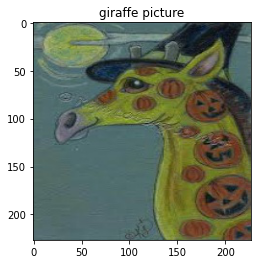

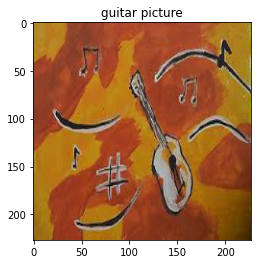

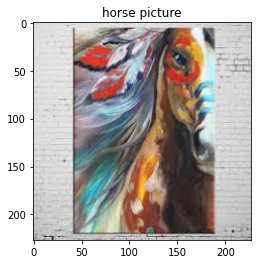

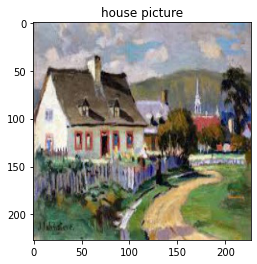

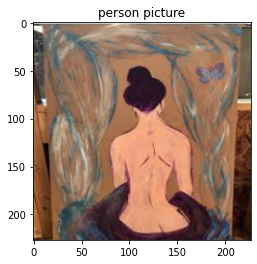

In [6]:
# train_set 이미지 살펴보기
for category in category_list:
  temp = train_set['img_dir'][train_set['category'] == category].iloc[0]
  img = mpimg.imread(os.path.join(train_path,temp))
  plt.imshow(img)
  plt.title(category + " picture")
  plt.show()

위 사진들만으로도 다음과 같은 특징을 발견할 수 있습니다.  
- 배경이 두가지인 그림 (dog picture)
- 의인화가 된 추상적인 그림 (elephant picture, giraffe picture)
- 분류 대상의 크기가 작은 그림 (guitar picture)
- 그림이 액자 형식으로 내부에 포함되어 있는 그림 (horse picture)


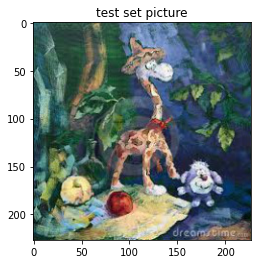

In [7]:
# test_set 이미지 살펴보기
plt.imshow(mpimg.imread(os.path.join(test_path,'0','0001.jpg')))
plt.title('test set picture')
plt.show()

- 역시 의인화 된 그림

### Label 별 개수 살펴보기

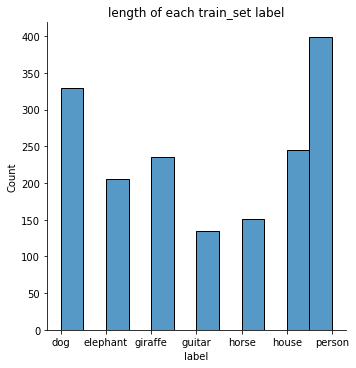

In [8]:
sns.displot(train_set['label'])
plt.title("length of each train_set label")
plt.xticks(np.arange(7), category_list)
plt.show()

label=3, "guitar"는 label=6, "person"에 비해 2배 이상 데이터 수가 부족한 모습을 보인다.  
즉, Class imbalance 문제가 있는 데이터셋임을 알 수 있다.

In [106]:
print("test_set 크기: ", len(test_set),"개")

test_set 크기:  350 개


## EDA 결과 분석

1. 주어진 데이터는 사진이 아닌 그림이다.
  - 따라서 ImageNet과 같은 실제 사진으로 pretrained된 모델은 잘 분류하지 못할 수도 있다.
  - 특히나 그림은 의인화, 화려한 배경, 실제와는 다른 과장 및 왜곡이 존재하기 때문에 이러한 문제는 critical한 요소이다.
2. 그림의 특성상 배경에도 많은 색 변화, 무늬 등이 존재하여 실제 학습에는 쓸모없는 정보임에도 유의미한 feature_map을 가지는 것처럼 보일 수 있다.
  - 특히 guitar picture에서 보이는 경우처럼 쓸모없는 정보 (배경, 음표 등)이 대부분을 차지하는 경우, 학습이 어려울 것으로 예상할 수 있다.
3. 데이터간의 class imabalance 문제가 존재한다.
4. 데이터의 수가 적다.

### 해결법 고안
1. 데이터가 많다면 처음부터 학습시키는 것이 좋겠지만, 이는 현실적으로 불가능하다.  
따라서 pretrained된 모델을 사용하되, `freeze_backbone = False` 를 적용하여 fine_tunning이 이루어지도록 한다.
2. 대부분의 이미지에서 class에 해당하는 객체는 이미지의 중앙 부분에 위치함을 확인하였다. `CenterCrop` augmentation을 통해 배경의 정보를 최대한 잘라내도록 한다.
3. 개수가 부족한 class에 대해 추가적인 augmentation을 적용하거나, `focal loss`와 같은 loss를 적용하여 문제를 해결한다.  
Stratified validation을 적용하여 학습 시 class의 수를 맞춰준다.
4. augmentation 적용, stratified validation, KFold ensemble, flip prediction 등의 방법을 적용하여 최대한 일반화 성능을 높인다.

# 데이터셋 만들기

In [13]:
class TrainDataset(data.Dataset):
  num_classes = 7 # 분류할 class의 개수

  image_paths = []
  labels = []

  def __init__(self, img_dir, transform=None):
    '''
    학습용 데이터셋을 만듭니다.
    
    Args:
        img_dir: 학습 이미지 폴더의 root directory
        transform: Augmentation을 하기 위함
    '''
    super().__init__()
    self.img_dir = img_dir # train_path = train/train
    self.category_list = ['dog','elephant','giraffe','guitar','horse','house','person']
    self.transform = transform

    self.setup()
  
  def set_transform(self, transform):
    self.transform = transform
  
  def setup(self):
    '''
    image의 경로, 각 이미지들의 label, RGB 평균값, std 를 저장
    '''
    img_info = dict(means=[], stds=[])

    for label, category in enumerate(self.category_list):
      files = os.listdir(os.path.join(self.img_dir,category))
      for file in tqdm(files):
        img_path = os.path.join(self.img_dir, category, file)
        self.image_paths.append(img_path)
        self.labels.append(label)

        img = np.array(Image.open(img_path))
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))

    self.mean = np.mean(img_info["means"], axis=0) / 255.
    self.std = np.mean(img_info["stds"], axis=0) / 255.

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    image = mpimg.imread(image_path)

    label = self.labels[index]
    
    # augmentation을 적용합니다.
    if self.transform:
      image_transform = self.transform(image=np.array(image))['image']
      return image_transform, label
    
    return image, label
    
  def __len__(self):
    return len(self.image_paths)

In [25]:
# Albumentations 라이브러리를 사용하여 Augmentation을 설정합니다.

def get_transforms(need=('train', 'val'), mean=None, std=None):
    transformations = {}
    if 'train' in need:
        transformations['train'] = A.Compose([
        # 대부분이 배경이고 물체가 중앙에 위치한 경우가 많은 점을 고려하여 centorcrop을 적용합니다.
            A.CenterCrop(200, 200, p=1.0), 
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = A.Compose([
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [15]:
# 데이터셋을 생성합니다.
dataset = TrainDataset(img_dir=train_path)

100%|██████████| 399/399 [03:14<00:00,  2.05it/s]


(227, 227, 3)


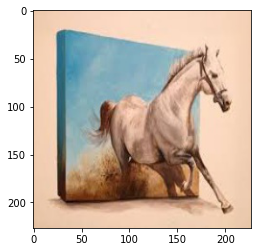

In [16]:
# 데이터셋이 잘 생성됐는지 확인합니다.
plt.imshow(dataset[1000][0])
plt.show
print(dataset[1000][0].shape)

## train, validation 분할

교차 검증을 위해 학습용 데이터셋과 검증용 데이터셋을 분할합니다.

StratifiedKfold 방식을 사용하여 label의 분포를 맞춰주면서 3개의 fold로 분할합니다.

In [26]:
num_k = 3
skf = StratifiedKFold(n_splits=num_k)

train_sets, val_sets = [], []

# 분할된 데이터셋 각각의 indeces를 저장합니다.
for train, val in skf.split(dataset.image_paths, dataset.labels): 
  train_sets.append(train)
  val_sets.append(val)

# 저장된 indices를 바탕으로 DataLoader를 만드는 함수
def get_kfold(k):
  train = data.Subset(dataset, train_sets[k])
  val = data.Subset(dataset, val_sets[k])

  # 각각에 대해서 transform을 적용합니다.
  transform = get_transforms(mean=dataset.mean, std=dataset.std)

  train.dataset.set_transform(transform['train'])
  val.dataset.set_transform(transform['val'])

  # train, validation 데이터 로더를 생성합니다.
  # train 데이터셋은 데이터를 섞어줍니다.
  train_loader = data.DataLoader(
      train,
      batch_size=8,
      num_workers=2,
      shuffle=True
  )

  val_loader = data.DataLoader(
      val,
      batch_size=8,
      num_workers=2,
      shuffle=False
  )
  return train_loader, val_loader

# 모델링

In [21]:
# 모델의 reproducibility를 위해 Seed를 고정합니다.
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # torch.cuda.manualseedall(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


## Configuration

In [97]:
seed_everything(777)

model_name = "tf_efficientnetv2_b0"  # 모델 이름
use_pretrained = True  # pretrained-model의 사용 여부
freeze_backbone = False 

batch_size = 8
num_workers = 2
num_classes = 7

num_epochs = 30  # 학습할 epoch의 수
lr = 1e-4

train_log_interval = 200  # logging할 iteration의 주기

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## 모델: tf_efficientnetv2_b0

최근 발표된 efficientnet의 최신 버전 efficientnetv2를 사용합니다.

efficientnet은 가볍고 빠르면서도 높은 정확도를 보이는 모델입니다.

이번 대회가 8시간이라는 짧은 시간동안 이루어진다는 점을 고려하여,  
빠르게 여러가지 실험을 통해 최적의 파라미터를 찾을 수 있는 모델이 필요하였습니다.

그러면서도 동시에 높은 정확도를 얻어야 했기에 EfficientNet을 사용하기로 하였습니다.  
또한 그 중에서도 가장 가벼운 모델인 b0 모델을 선택하여 다양한 실험을 가능하도록 하였습니다.

In [98]:
# KFold를 실행합니다. k = 3
for k in range(num_k):
  counter = 0
  best_val_acc = 0
  best_val_loss = np.inf
  
  # fold에 맞는 dataloader를 불러옵니다.
  train_loader, val_loader = get_kfold(k)

  # pretrained 모델을 불러오고, 현재 작업에 맞게 classifier를 고칩니다.
  m = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
  m.classifier = nn.Linear(1280, num_classes)

  model = m.to(device)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-6)

  # 모델을 저장할 폴더를 만듭니다.
  os.makedirs(os.path.join(PATH,f"results/{k}"), exist_ok=True)

  # 학습을 시작합니다.
  for epoch in range(num_epochs):

      # train loop
      model.train()
      loss_value = 0
      matches = 0
      for idx, train_batch in enumerate(train_loader):
          inputs, labels = train_batch
          inputs = inputs.to(device)
          labels = labels.to(device)

          outs = model(inputs)
          preds = torch.argmax(outs, dim=-1)
          loss = criterion(outs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_value += loss.item()
          matches += (preds == labels).sum().item()
          if (idx + 1) % train_log_interval == 0:
              train_loss = loss_value / train_log_interval
              train_acc = matches / batch_size / train_log_interval
              print(
                  f"Epoch[{epoch}/{num_epochs}]({idx + 1}/{len(train_loader)}) || "
                  f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
              )

              loss_value = 0
              matches = 0

      # val loop
      with torch.no_grad():
          print("Calculating validation results...")
          model.eval()
          val_loss_items = []
          val_acc_items = []
          for val_batch in val_loader:
              inputs, labels = val_batch
              inputs = inputs.to(device)
              labels = labels.to(device)

              outs = model(inputs)
              preds = torch.argmax(outs, dim=-1)

              loss_item = criterion(outs, labels).item()
              acc_item = (labels == preds).sum().item()
              val_loss_items.append(loss_item)
              val_acc_items.append(acc_item)

          val_loss = np.sum(val_loss_items) / len(val_loader)
          val_acc = np.sum(val_acc_items) / len(val)
          
          # validation accuracy가 향상될때만 모델을 저장합니다.
          if val_loss < best_val_loss:
              best_val_loss = val_loss
          if val_acc > best_val_acc:
              print("New best model for val accuracy! saving the model..")
              torch.save(model.state_dict(), os.path.join(PATH,f"results/{k}/{model_name}.pt"))
              best_val_acc = val_acc
              counter = 0
          else:
              counter += 1
          
          print(
              f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
              f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
          )

Calculating validation results...
New best model for val accuracy! saving the model..
[Val] acc : 90.46%, loss: 0.66 || best acc : 90.46%, best loss: 0.66
Calculating validation results...
New best model for val accuracy! saving the model..
[Val] acc : 93.11%, loss: 0.28 || best acc : 93.11%, best loss: 0.28
Calculating validation results...
[Val] acc : 92.76%, loss: 0.26 || best acc : 93.11%, best loss: 0.26
Calculating validation results...
New best model for val accuracy! saving the model..
[Val] acc : 95.23%, loss: 0.19 || best acc : 95.23%, best loss: 0.19
Calculating validation results...
[Val] acc : 93.46%, loss: 0.22 || best acc : 95.23%, best loss: 0.19
Calculating validation results...
[Val] acc : 94.52%, loss:  0.2 || best acc : 95.23%, best loss: 0.19
Calculating validation results...
[Val] acc : 92.23%, loss: 0.23 || best acc : 95.23%, best loss: 0.19
Calculating validation results...
[Val] acc : 93.46%, loss: 0.21 || best acc : 95.23%, best loss: 0.19
Calculating validati

# Predict

## Test dataset 만들기

In [56]:
class TestDataset(data.Dataset):
  def __init__(self, img_dir, transform=None):
    super().__init__()
    self.img_dir = img_dir # test_path = test/test
    self.transform = transform
  
  def __getitem__(self, index):
    image_path = self.img_dir[index]
    image = mpimg.imread(image_path)

    if self.transform:
      image = self.transform(image=np.array(image))['image']

    return image
    
  def __len__(self):
    return len(self.img_dir)

## predict

In [99]:
# submission을 위해 sample submission 파일을 불러옵니다.
submission = pd.read_csv(os.path.join(PATH, 'test_answer_sample_.csv'))

def get_test():
  # 이미지를 불러오고 transform을 정의 해줍니다.
  test_image_dir = os.path.join(test_path, '0')
  image_paths = [os.path.join(test_image_dir, img_id) for img_id in os.listdir(test_image_dir)]
  
  # image가 무작위 순서로 불러와져 있기 때문에 반드시 submission과 맞춰주어야 합니다.
  # 여기서는 간단하게 path list에 sort() 함수를 적용했습니다.
  image_paths.sort()
  transform = A.Compose([
      A.Normalize(mean=dataset.mean, std=dataset.std),
      ToTensorV2(),
  ])

  # Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
  test_dataset = TestDataset(image_paths, transform)

  # test data는 shuffle 하지 않습니다.
  test_loader = data.DataLoader(
      test_dataset,
      shuffle=False
  )
  return test_loader

In [103]:
counter = 0
best_val_acc = 0
best_val_loss = np.inf
oof_pred = None

test_loader = get_test()

for fold in range(num_k):
  # 각 fold 별로 최고의 성능을 보인 모델을 불러옵니다.
  model_path = os.path.join(PATH,f"results/{k}/{model_name}.pt")
  checkpoint = torch.load(model_path, map_location=device)

  with torch.no_grad():
      all_predictions = []
      for images in test_loader:
          images = images.to(device)

          # Test Time Augmentation
          pred = model(images) # 원본 이미지를 예측하고
          pred += model(torch.flip(images, [0, 1])) / 2 # flip으로 뒤집어 예측합니다. 
          all_predictions.extend(pred.cpu().numpy())

      fold_pred = np.array(all_predictions)

  # 각 모델의 pred 값을 통합합니다.
  if oof_pred is None:
      oof_pred = fold_pred 
  else:
      oof_pred += fold_pred 

마지막으로 test 과정에서도 일반화 성능을 높이기 위해  
원본 이미지를 예측하고, 뒤집은 이미지를 예측한 값을 앙상블 해주는 방법을 적용합니다.

# Submission

In [104]:
# 각 모델의 예측값 앙상블을 통해 일반화 성능을 확보하고,
# 이를 저장하여 제출합니다.
submission['answer value'] = np.argmax(oof_pred, axis=1)
submission.to_csv(os.path.join(PATH, f'submission_{model_name}_{num_epochs}3.csv'), index=False)
print('Submission File Created!')

print("GOOD LUCK!")

Submission File Created!
GOOD LUCK!
